# Gradient Boosting

## Introduction: Feedback Loops

>Today, numerous classical control systems depend on feedback loops. Feedback loops work by repeatedly taking a measurement and subsequently taking an action to push the value measured towards the desired value.

Gradient boosting implements this for ML models by having a sequence of models whose outputs are added together, where the next model is trained to correct the error of the previous one.

## Introduction: Gradient Boosting

>Gradient boosting is another ensemble method similar to bagging and boosting. It is typically implemented using decision trees as the models. 

Similar to the case with boosting, the objective of creating an ensemble via gradient boosting is to increase the capacity of the overall model, rather than regularise it, as is the case in bagging.

We will begin by exploring gradient boosting for regression. For this, a dataset with continuous features and a differentiable loss function are required.

### Regular boosting vs gradient boosting

#### Similarities

- Gradient boosting produces a sequence of models whose predictions are added together to realise a final prediction.
- It is typically implemented with decision trees as the models.

#### Differences
For gradient boosting,
- the models built **predict the pseudo residuals between the previous model's predictions and the ideal output** (more on this shortly).
- the models' predictions are all combined with an equal weight, which is called the learning rate (we will discuss the relationship with gradient descent shortly), except for the base (first) model, whose prediction is not weighted.
- all models are trained on the entire original dataset, rather than a dataset bootstrapped from it.
- the decision trees built by gradient boosting may be larger than stumps (decision trees with ```max_depth=1```).

![](images/gradient_boosting_summary.jpg)


### Predictions from the base (first) model

Gradient boosting starts by outputting a single prediction for all examples, i.e. by predicting the same constant value, $c$, for all of them.

$$h_0(x) = c$$

However, the question of interest becomes, 'what is the best value of $c$, which we will call $c^*$?' 
To provide an answer, we determine the value of $c$ that would minimise the MSE objective.

![](images/best_constant.jpg)

As can be observed, the constant that is predicted as the label for every example, which minimises the MSE, is the mean of the labels in the dataset.

### Predictions from the following sequence of models

Therefore, gradient boosting sequentially adds to the total hypothesis by making trees that correct for the error made thus far and adding those predictions scaled by a learning rate, $\alpha$.

![](images/gradient_boosting_hypothesis.jpg)

To correct for the error made by the sequence thus far, each successive tree predicts a value that when added to the hypothesis, would reduce the loss for that example.

The adjustment that is required for each example depends on the error resulting from the latest prediction. A positive error is indicative of an overly high estimate; thus, we need to drive it in the negative direction. The same applies in the case of a negative error.

## Gradient Boosting vs Gradient Descent

You may have noticed some similarities between __gradient boosting and gradient descent.__ In fact, they are implemented in almost the same way. 

We take the derivative of the loss with respect to the prediction of the sequence thus far, and shift that prediction in that direction, proportionally to that value.

This is the origin of the name, gradient boosting: each sequential model boosts the predictions of the previous one by adjusting its prediction in a direction that reduces the error, by following the gradient of the loss with respect to the most recent prediction downhill.

>The difference between gradient descent for optimisation and gradient boosting is that this shifting process does not update the model parameters, but updates the prediction; further, it is not done whilst training, but whilst making predictions. Gradient descent is an optimisation algorithm, whereas gradient boosting is a model.

The derivative tells us which direction to move our prediction to **increase** the error, which is definitely the opposite direction in which we intend to adjust it.
Thus, as with gradient descent, we move in the direction of the negative gradient, rather than the positive. Additionally, we scale the update based on the same learning rate that we saw previously in gradient descent.
It is a value between zero and 1.

Only during training do we have access to the ground truth labels for each example, which is required to compute the gradient. Therefore, we have to train the trees to predict the gradients which will be used to update the predictions.

### Residuals and pseudo residuals

When we evaluate the half square loss function for a particular example, its derivative affords the exact error. The negative of this error is what more needs to be added to the prediction for it to reach the true label, i.e. **the residual**.

![](images/residual.jpg)

When using other loss functions, such as the MSE loss for simplicity, or the cross entropy loss for classification, the derivative, which provides information on the update required to make the predictions, is not equal to the residual.
In this case, we call the update quantities **pseudo residuals**.

**Each successive tree in the sequence is fit to predict this pseudo residual (the gradient).** 

In general, the pseudo residual is given by
$r_{il} = - [\frac{\partial L(H(x_i), y_i)}{\partial H(x_i)}]_{H(x)=H_{l-1}(x)}$ 

Here is how gradient boosting drives the predictions closer to the label in the same way that gradient descent does.

![](images/gradient_boosting_vs_gradient_descent.jpg)

## Example

### Hyperparameters
- Size of trees: specify the maximum depth of the tree as the maximum number of leaves.
- Number of models in sequence

### Algorithm overview

- Build a base predictor that predicts the final label for all examples in the dataset to be equal to the mean of the labels of the dataset.
- For as many models as you want in your gradient-boosting sequence, do the following:
    - For each example in the dataset, set the new target equal to the pseudo residual of the predictions made by the combination of the preceding models.
    - Train a model to predict this error and add it to the sequence of gradient-boosting models.

In [ ]:
# Run this cell to download the necessary package to run the next cells
!wget "https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/get_colors.py" "https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/utils.py"

(20, 1) (20, 1)


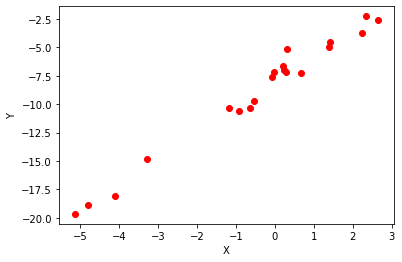

In [2]:
from utils import get_regression_data, show_regression_data, visualise_regression_predictions

X, Y = get_regression_data()
show_regression_data(X, Y)

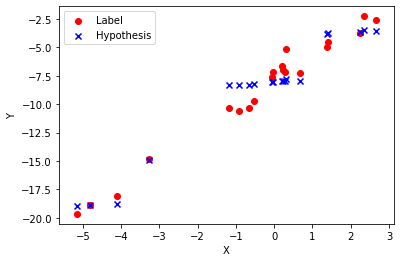

16.47059166473123

In [9]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import json

class GradientBoostedDecisionTree:
    def __init__(self, n_trees=10, learning_rate=0.1):
        self.n_trees = n_trees
        self.learning_rate = learning_rate

    def calc_loss(self, predictions, labels):
        return 0.5 * np.sum((predictions - labels)**2)

    def calc_loss_gradient(self, predictions, labels):
        # print('labels:', labels.shape)
        # print('predictions:', predictions.shape)
        # print((labels - predictions).shape)
        return labels - predictions # in the case of MSE loss the gradient is equal to the residual

    def fit(self, X, Y):
        labels = Y
        self.trees = []
        losses = []
        for tree_idx in range(self.n_trees):
            # print(f'training tree {tree_idx}')
            tree = DecisionTreeRegressor(max_depth=2)
            tree.fit(X, labels)
            predictions = tree.predict(X)
            predictions = predictions.reshape(-1, 1)
            labels = self.calc_loss_gradient(predictions, labels) # calculate residual
            self.trees.append(tree)
            # print()

    def predict(self, X):
        predictions = np.zeros((len(X), 1))
        for tree_idx, tree in enumerate(self.trees):
            this_prediction = tree.predict(X).reshape(-1, 1)
            if tree_idx == 0:
                predictions += this_prediction
            else:
                predictions += self.learning_rate * tree.predict(X).reshape(-1, 1)
        
        return predictions

    def __repr__(self):
        return json.dumps([{'depth': t.max_depth} for t in self.trees])

gradientBoostedDecisionTree = GradientBoostedDecisionTree()
gradientBoostedDecisionTree.fit(X, Y)
predictions = gradientBoostedDecisionTree.predict(X)
visualise_regression_predictions(X, predictions, Y)
gradientBoostedDecisionTree.calc_loss(predictions, Y)

## Model Types Other Than Decision Trees

__Would gradient boosting work for model types other than decision trees?__

Refer to the expression that describes how the predictions of the models in the gradient-boosting sequence are combined. You can see that the models are combined linearly. If each model is a linear model, such as the straight-line function that we implemented for linear regression, then the final prediction will be a linear combination of linear combinations of the example features.
Evaluating this, it becomes evident that the final prediction can be expressed as a single linear combination of features. Therefore, applying gradient boosting to any linear model is an exercise in futility, as it does not increase the model's capacity.

However, applying gradient boosting to a non-linear model, such as a polynomial, would result in a final prediction expression that could not be simplified in such a way. This would increase the model's capacity, which is the point of ensembling via gradient boosting.

## Conclusion
At this point, you should have a good understanding of 

- gradient-boosting algorithms.
- how to implement gradient boosting.